In [1]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


In [2]:
def read_file(filename):
    # Regex pattern to match experiment header and time
    header_pattern = r"file_name: (\w+), chunk_size: (\d+), output_len: (\d+)"
    time_pattern = r"Time: (\d+\.\d+)"

    experiments = defaultdict(list)

    # Read file
    with open(filename, 'r') as f:
        lines = f.readlines()

    experiment_key = None
    for line in lines:
        header_match = re.match(header_pattern, line)
        if header_match:
            experiment_key = header_match.groups()
        else:
            time_match = re.match(time_pattern, line)
            if time_match:
                experiments[experiment_key].append(float(time_match.group(1)))

    # Compute averages
    averages = {key: sum(times)/len(times) for key, times in experiments.items()}
    return averages


In [3]:
parrot = read_file('parrot_main.log')
vllm = read_file('fschat_vllm.log')
hf = read_file('fschat_fs.log')

In [4]:
outlens = [25, 50, 75, 100]

In [5]:
print('parrot', parrot)
print('vllm', vllm)
print('hf', hf)

parrot {('article_0', '512', '50'): 165.5173, ('article_0', '1024', '50'): 85.8414, ('article_0', '1536', '50'): 59.5863, ('article_0', '2048', '50'): 46.9762, ('article_1', '512', '50'): 102.3529, ('article_1', '1024', '50'): 53.6686, ('article_1', '1536', '50'): 36.8621, ('article_1', '2048', '50'): 28.4428, ('article_2', '512', '50'): 117.685, ('article_2', '1024', '50'): 61.0197, ('article_2', '1536', '50'): 43.219, ('article_2', '2048', '50'): 33.7308, ('article_3', '512', '50'): 100.9875, ('article_3', '1024', '50'): 52.1034, ('article_3', '1536', '50'): 36.5574, ('article_3', '2048', '50'): 28.0492, ('article_4', '512', '50'): 135.8771, ('article_4', '1024', '50'): 70.6289, ('article_4', '1536', '50'): 48.7767, ('article_4', '2048', '50'): 38.2011, ('article_5', '512', '50'): 128.1361, ('article_5', '1024', '50'): 67.2044, ('article_5', '1536', '50'): 46.3471, ('article_5', '2048', '50'): 36.8707, ('article_6', '512', '50'): 231.8159, ('article_6', '1024', '50'): 119.0058, ('art

In [6]:

# output_lengths = ['25', '50', '75', '100']
chunk_sizes = ['512', '1024', '1536', '2048']
systems = ['parrot', 'vllm', 'hf']
hatches = ['', '\\', '/']
colors = [
"#d73027",
"#fc8d59",
"#4575b4"]

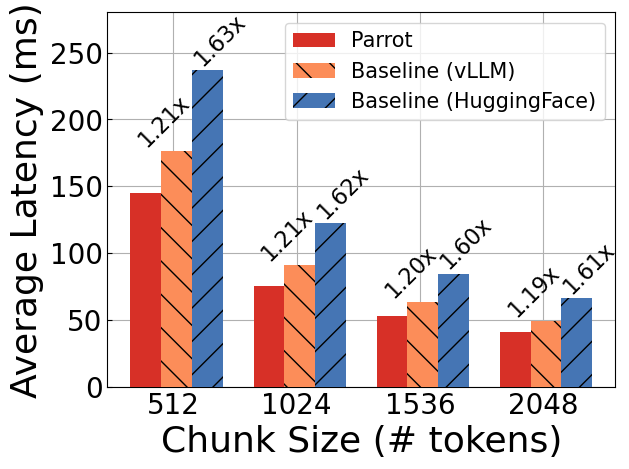

In [7]:
# Organize the data
data = {
    "parrot": parrot,
    "vllm": vllm,
    "hf": hf
}

names = {
    "parrot": "Parrot",
    "vllm": "Baseline (vLLM)",
    "hf": "Baseline (HuggingFace)"
}

statistics = {ol: {s: [] for s in systems} for ol in chunk_sizes}

for system, system_data in data.items():
    for key, value in system_data.items():
        chunk_size = key[1]
        statistics[chunk_size][system].append(value)

# Calculate statistics
averages = {ol: {s: np.mean(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
mins = {ol: {s: np.min(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}
maxs = {ol: {s: np.max(values) for s, values in ol_data.items()} for ol, ol_data in statistics.items()}

# Generate the chart
x = np.arange(len(chunk_sizes))
width = 0.25

fig, ax = plt.subplots()


plt.grid(True)
for i, system in enumerate(systems):
    avg = [averages[ol][system] for ol in chunk_sizes]
    min_ = [mins[ol][system] for ol in chunk_sizes]
    max_ = [maxs[ol][system] for ol in chunk_sizes]
    
    rects = ax.bar(x - width/2 + i*width, avg, width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    
    # Add speedup values
    if system != 'parrot':
        speedup_values = [averages[ol][system]/averages[ol]['parrot'] for ol in chunk_sizes]
        for rect, speedup in zip(rects, speedup_values):
            height = rect.get_height()
            diff = 0.1 if system == 'vllm' else -0.1
            ax.text(rect.get_x() + rect.get_width() / 2 -diff, height,
                    '{:.2f}x'.format(speedup),
                    ha='center', va='bottom', rotation=45,
                    fontsize=16)
            
plt.legend(loc='upper right', prop = { "size": 15 },)
ax.tick_params(axis='y', labelsize=20, direction='in')
ax.tick_params(axis='x', labelsize=20, direction='in')
ax.set_xlabel('Chunk Size (# tokens)', fontsize=26)
ax.set_ylabel('Average Latency (ms)', fontsize=26)
ax.set_xticks([_+0.1 for _ in x])
ax.set_xticklabels(chunk_sizes)
plt.ylim([0,280])

fig.tight_layout()

plt.savefig('chain-single-csize.pdf')

25
1.8759961098577047
1.3833286156212998
50
1.6379719264214698
1.2054189561852335
75
1.54553536074003
1.140709259859997
100
1.5180108710426727
1.1077330776953116


In [8]:
averages['1024']

{'parrot': 75.42657, 'vllm': 91.15404, 'hf': 122.16704999999999}